# **ALFA dataset Anomaly MUlti Class Classificataion using Mcfly module reference, torch Windows 40**

**Anomaly Classification using CNN**

In [1]:
!pip install sktime
!pip install mcfly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 62.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


## **Setup Dependencies**

In [2]:
import os
import sys
import json
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from collections import Counter
from sktime.datatypes import convert_to
from timeit import default_timer as timer
from sktime.datasets import load_from_tsfile
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sktime.datasets import load_from_tsfile_to_dataframe
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from mcfly.modelgen import generate_models
from mcfly.find_architecture import find_best_architecture
from mcfly.find_architecture import train_models_on_samples
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import torch

warnings.filterwarnings('ignore')
np.random.seed(42)

2024-07-28 13:06:09.728188: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-28 13:06:09.728295: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-28 13:06:09.852163: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## **Load Dataset**

The given size (N, seq_len, features) applicable for mcfly

In [3]:
# no rolling stats
X = np.load('/kaggle/input/alfa-seq-dataset/ALFA_seq_dataset_complete/alfa_dataset_complete_sequence_X.npy')
y = np.load('/kaggle/input/alfa-seq-dataset/ALFA_seq_dataset_complete/alfa_dataset_complete_sequence_y.npy')
print(X.shape)
print(y.shape)

(3482, 40, 17)
(3482,)


**Swapaxes, output shape (N,features,seq_len), its required for pytorch**

In [67]:
X = np.swapaxes(X, 1, 2)
X.shape

(3482, 17, 40)

#### **Z-score normalize**

In [4]:
mean = np.mean(X, axis=(0,2), keepdims=True)
std = np.std(X, axis=(0, 2), keepdims=True)
X_norm = (X - mean) / std
print(X_norm.shape)

(3482, 40, 17)


**Label encoding**

Applicable for mcfly only

In [5]:
ohe = OneHotEncoder()

y = ohe.fit_transform(y.reshape(-1, 1)).toarray()
y.shape

(3482, 5)

## **Train valid test split**

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.10, random_state=40,
                                                    shuffle=True, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.10, random_state=40,
                                                  shuffle=True, stratify=y_train)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(2819, 40, 17) (314, 40, 17) (349, 40, 17)
(2819, 5) (314, 5) (349, 5)


#### **Class weights**

In [7]:
class_weights = compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(np.argmax(y, axis=1)),
    y = np.argmax(y, axis=1)
)

class_weights = dict(zip(np.unique(np.argmax(y, axis=1)), class_weights))
class_weights

{0: 0.2682588597842835,
 1: 3.553061224489796,
 2: 3.0278260869565217,
 3: 3.0278260869565217,
 4: 3.0278260869565217}

## **Automatically find the models and model selection**

Selecting reference model using mcfly, finding between different CNN

In [8]:
%%time

file_name = f"model-comparison-20220808.json"
output_file = os.path.join("/kaggle/working/", file_name)
model_path = os.path.join("/kaggle/working/")

metric_key = "pr_auc"
metric = AUC(curve="PR", name=metric_key )

# metric_key = "accuracy"
# metric = "accuracy"

models = generate_models(
    X_train.shape,
    y_train.shape[1],
    number_of_models=3,
    model_types=['CNN'],
    metrics=[metric]
)

history, val_metrics, val_losses = train_models_on_samples(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    models=models,
    nr_epochs=30,
    verbose=True,
    model_path=model_path,
    outputfile=output_file,
    subset_size=int(X_train.shape[0] / 2),
    class_weight=class_weights
)

Generated models will be trained on subset of the data (subset size: 1409).
Training model 0 CNN
Epoch 1/30


I0000 00:00:1722172062.823921     124 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


71/71 [==============================] - 13s 29ms/step - loss: 1.7378 - pr_auc: 0.2400 - val_loss: 1.8291 - val_pr_auc: 0.1758
Epoch 2/30
71/71 [==============================] - 1s 13ms/step - loss: 1.2536 - pr_auc: 0.3404 - val_loss: 1.5863 - val_pr_auc: 0.3465
Epoch 3/30
71/71 [==============================] - 1s 13ms/step - loss: 0.9939 - pr_auc: 0.4516 - val_loss: 1.4133 - val_pr_auc: 0.4705
Epoch 4/30
71/71 [==============================] - 1s 13ms/step - loss: 0.8454 - pr_auc: 0.5143 - val_loss: 1.6171 - val_pr_auc: 0.3791
Epoch 5/30
71/71 [==============================] - 1s 13ms/step - loss: 0.7519 - pr_auc: 0.5611 - val_loss: 1.6185 - val_pr_auc: 0.3713
Epoch 6/30
71/71 [==============================] - 1s 13ms/step - loss: 0.6845 - pr_auc: 0.6232 - val_loss: 1.9489 - val_pr_auc: 0.3268
Epoch 6: early stopping
Training model 1 CNN
Epoch 1/30
71/71 [==============================] - 8s 22ms/step - loss: 1.9573 - pr_auc: 0.2512 - val_loss: 2.1217 - val_pr_auc: 0.2372
Epoch 

#### **Returning best model type**

In [9]:
best_model_index = np.argmax(val_metrics[metric_key])
best_model, best_params, best_model_type = models[best_model_index]

print(best_model_index)
print("Best model type:", best_model_type)

1
Best model type: CNN


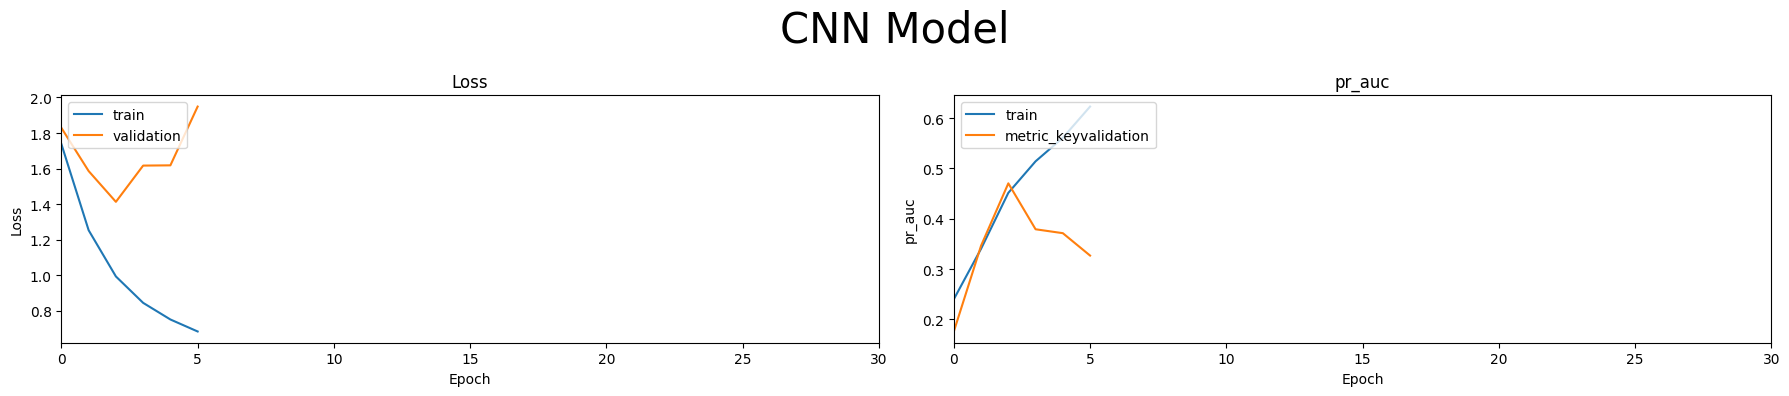

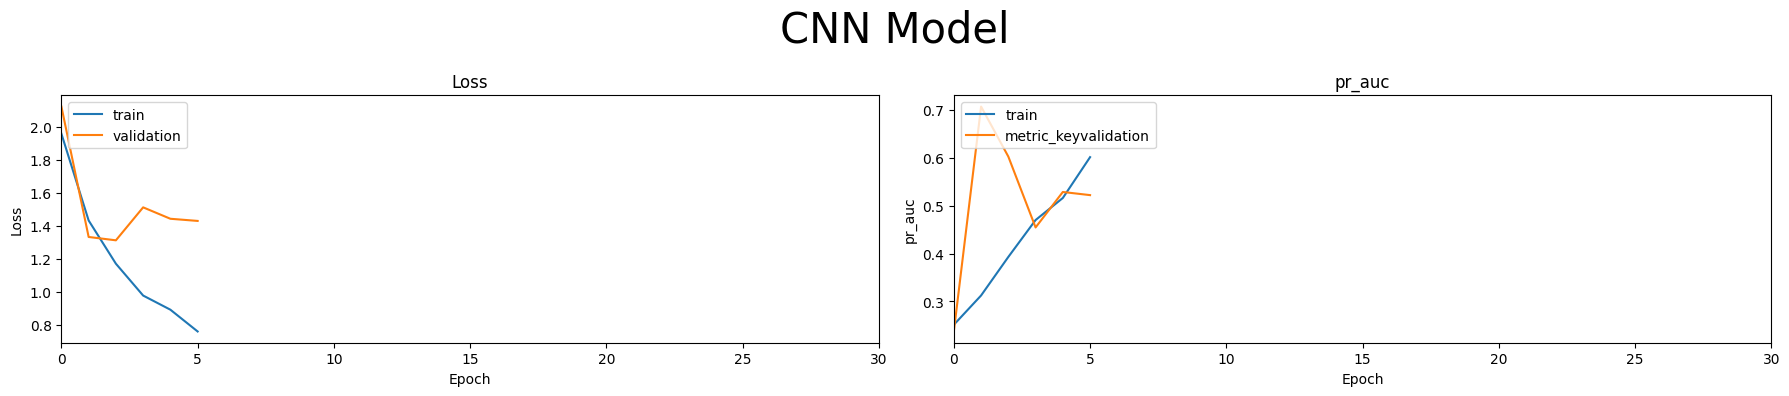

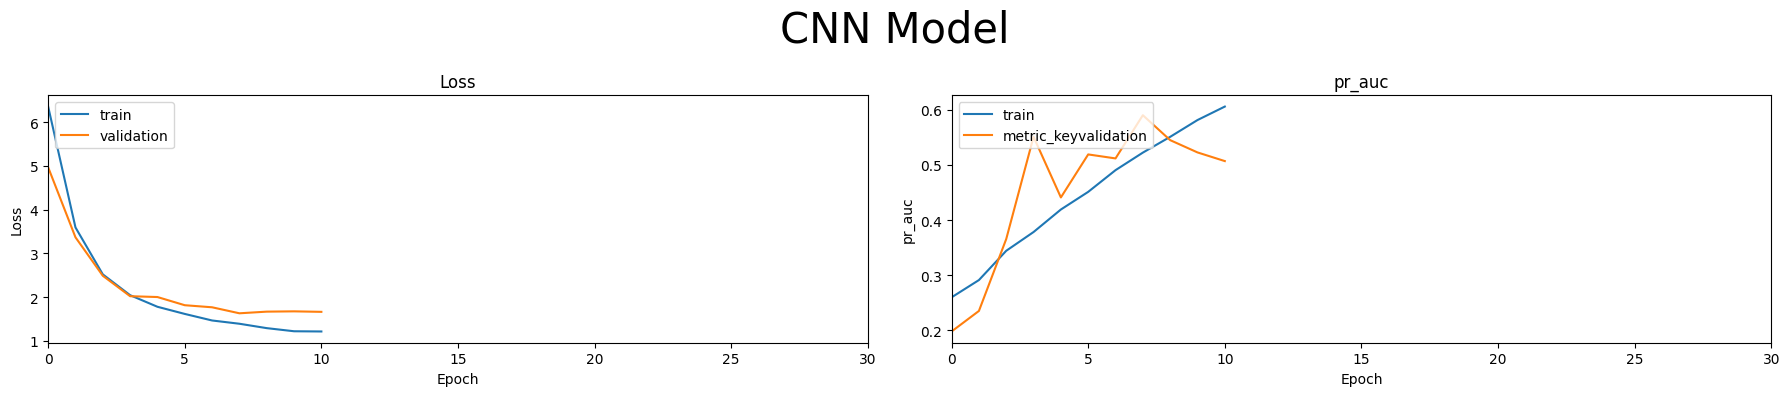

In [10]:
model_types = list(map(lambda m: m[2],models))

for i in range(len(model_types)):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18, 4))

    fig.suptitle(f"{model_types[i]} Model", fontsize=30)

    ax1.plot(history[i].history['loss'])
    ax1.plot(history[i].history['val_loss'])
    ax1.set_title('Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_xlim([0, 30])
    ax1.legend(['train', 'validation'], loc='upper left')

    ax2.plot(history[i].history[metric_key])
    ax2.plot(history[i].history[f'val_{metric_key}'])
    ax2.set_title(metric_key)
    ax2.set_ylabel(metric_key)
    ax2.set_xlabel('Epoch')
    ax2.set_xlim([0, 30])
    ax2.legend(['train', 'metric_keyvalidation'], loc='upper left')

    plt.tight_layout()
    plt.show()

## **Training**

**Callbacks**

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
checkpoint_path = 'best_model.h5'

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)


## **Model Training**

In [16]:
%%time

history = best_model.fit(
    X_train,
    y_train,
    epochs=20,
    callbacks=[early_stopping, checkpoint_callback],
    validation_data=(X_val, y_val),
)

Epoch 1/20
88/89 [============================>.] - ETA: 0s - loss: 0.2497 - pr_auc: 0.9903
Epoch 1: val_loss did not improve from 0.23027
89/89 [==============================] - 1s 12ms/step - loss: 0.2517 - pr_auc: 0.9884 - val_loss: 0.2636 - val_pr_auc: 0.9722
Epoch 2/20
88/89 [============================>.] - ETA: 0s - loss: 0.2544 - pr_auc: 0.9877
Epoch 2: val_loss did not improve from 0.23027
89/89 [==============================] - 1s 11ms/step - loss: 0.2544 - pr_auc: 0.9877 - val_loss: 0.2860 - val_pr_auc: 0.9831
Epoch 3/20
86/89 [===========================>..] - ETA: 0s - loss: 0.2605 - pr_auc: 0.9870
Epoch 3: val_loss did not improve from 0.23027
89/89 [==============================] - 1s 11ms/step - loss: 0.2611 - pr_auc: 0.9862 - val_loss: 0.2621 - val_pr_auc: 0.9763
Epoch 4/20
86/89 [===========================>..] - ETA: 0s - loss: 0.2403 - pr_auc: 0.9899
Epoch 4: val_loss did not improve from 0.23027
89/89 [==============================] - 1s 12ms/step - loss: 0.24

## **Evaluate**

**In case evaluate from best model**

In [36]:
# load the best checkpoint model
from keras.models import load_model
best_model = load_model('/kaggle/working/best_model.h5')
#model.summary()

**Predict**

In [17]:
import time

t = time.time()
y_pred = best_model.predict(X_test, batch_size=1)
print(time.time() - t)

349/349 [==============================] - 1s 2ms/step
1.0220861434936523


#### **Classification Metrics for Multi Class CNN window size=40**

#### **Confusion Matrix**

Classification report fot the CNN model:

              precision    recall  f1-score   support

           0     0.9846    0.9808    0.9827       260
           1     1.0000    0.8000    0.8889        20
           2     0.7778    0.9130    0.8400        23
           3     0.9500    0.8261    0.8837        23
           4     0.8519    1.0000    0.9200        23

    accuracy                         0.9570       349
   macro avg     0.9128    0.9040    0.9031       349
weighted avg     0.9608    0.9570    0.9572       349



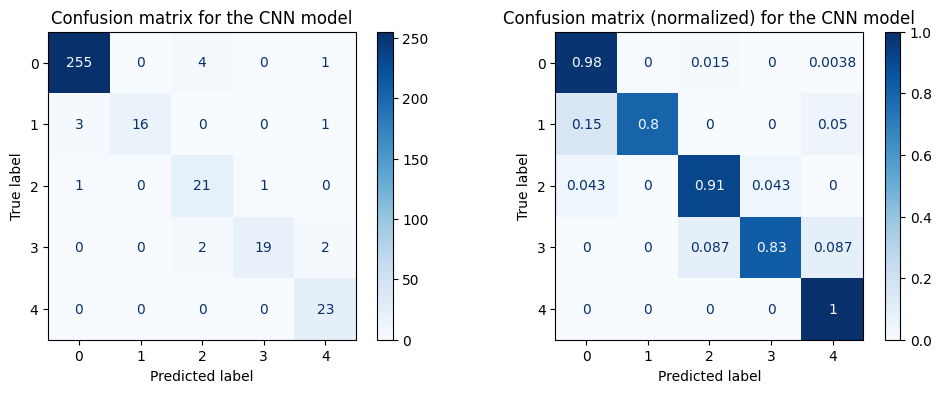

In [19]:
print(f"Classification report fot the CNN model:\n")
print(
    classification_report(
        np.argmax(y_test, axis=1),
        np.argmax(y_pred, axis=1),
        digits=4
    )
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ConfusionMatrixDisplay.from_predictions(
    np.argmax(y_test, axis=1),
    np.argmax(y_pred, axis=1),
    display_labels=list(ohe.categories_[0]),
    normalize=None,
    cmap="Blues",
    ax=ax1
)

ax1.set_title(f"Confusion matrix for the {best_model_type} model")

ConfusionMatrixDisplay.from_predictions(
    np.argmax(y_test, axis=1),
    np.argmax(y_pred, axis=1),
    display_labels=list(ohe.categories_[0]),
    normalize="true",
    cmap="Blues",
    ax=ax2
)

ax2.set_title(f"Confusion matrix (normalized) for the {best_model_type} model")
plt.show()

--**THE END**--